Simulated planet is 2 days, 2 hours, and 0.04% depth.

Light curve has Autoregressive ARMA(3, 3) noise and no detrending has been performed to better showcase the properties of BLS in correlated noise.

Code used:

```R
> source('utils.R')
> yt <- getLightCurve(2, 0.04, 2, noiseType=2, seedValue=42)
[1] "Length of time series = 1071"
[1] "==== Simulated light curve parameters ===="
[1] Period (hours) =  48.000
[1] Depth =  0.040000
[1] Transit duration (hours) =  2.000
[1] "=========================================="
> y<-yt[[1]]
> t<-yt[[2]]
> df <- data.frame(y=y, t=t/24, err=rep(0, length(t)))
> write.table(df, "ar_transit", col.names=FALSE, row.names=FALSE, quote=FALSE)
```

To get GPR fit:
```R
> gp <- gausspr(df$t, df$y)
Using automatic sigma estimation (sigest) for RBF or laplace kernel 
> predicted_y <- predict(gp, df$t)
> gpr_df <- data.frame(predicted_y=predicted_y, time=df$t)
> write.table(gpr_df, "gausspr_fit", col.names=FALSE, row.names=FALSE, quote=FALSE)
```

<!-- To store the undifferenced light curve and undifferenced ARMA model:
```R
> xy <- undifferenceATimeSeries(diff(df$y), df$y[1])
> write.table(xy, "undiff_lc", col.names=FALSE, row.names=FALSE, quote=FALSE)
```
-->

To get ARIMA fit on differenced light curve:
```R
> arima_fit<-getResidForTCF(y)
Series: diff(y) 
ARIMA(0,0,5) with zero mean 

Coefficients:
          ma1     ma2     ma3      ma4      ma5
      -0.4973  0.1085  0.1342  -0.2783  -0.1256
s.e.   0.0304  0.0346  0.0369   0.0329   0.0321

sigma^2 = 1.3e-08:  log likelihood = 8198.65
AIC=-16385.3   AICc=-16385.22   BIC=-16355.45
> arima_df <- data.frame(arima_fit=fitted(arima_fit), time=head(df$t, -1))
> write.table(arima_df, "arima_fit", col.names=FALSE, row.names=FALSE, quote=FALSE)
```

To get TCF periodogram and save it:

First, save the periods used for BLS periodogram:
```python
p = np.linspace(0.5, 22.2916666667, 21420)
np.save('bls_periods.npy', p)
```
then
```R
period <- 2
duration <- 2
res <- 2
ofac <- 2
useOptimalFreqSampling <- FALSE
algo <- 'TCF'
lctype <- 'sim'
freqGrid <- getFreqGridToTest(t, period, duration, res=res, ofac=ofac, useOptimalFreqSampling=useOptimalFreqSampling, algo=algo, lctype=lctype)
fstep <- (max(freqGrid) - min(freqGrid)) / length(freqGrid)
freqs <- seq(from = min(freqGrid), by = fstep, length.out = length(freqGrid))
periodsToTry <- 1 / freqs

library(reticulate)
np <- import("numpy")
# data reading
mat <- np$load("bls_periods.npy")
mat <- mat * 24  # Convert to hours.

# Empirical observation: In reality, applying ARMA when Gaussian noise is present will give another Gaussian, so is not that helpful.
# However, for some reason, it was found to be important to keep ARMA irrespective of the noise to get expected results.
# Hence we apply ARMA even if Gaussian noise is present.
tresidTCF <- getResidForTCF(y)
output <- tcf(tresidTCF, p.try = mat * res, print.output = TRUE)
powmax.loc = which.max(output$outpow)
perResults <- c(output$inper[powmax.loc]/res, output$outdepth[powmax.loc], output$outdur[powmax.loc]/res)
output <- output$outpow
periodAtMaxOutput <- mat[which.max(output)]
tcf_periodogram <- data.frame(power=output, periods=mat)
write.table(tcf_periodogram, "tcf_periodogram", col.names=FALSE, row.names=FALSE, quote=FALSE)
```

In [1]:
import numpy as np
import pandas as pd
from astropy.time import Time
import astropy.units as u
from datetime import datetime, timedelta
import lightkurve as lk

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
df = pd.read_csv('ar_transit', sep=' ', header=None)
df.columns = ['flux', 'time', 'flux_err']
df

,flux,time,flux_err
0,0.999690,0.000000,0
1,0.999887,0.020833,0
2,0.999774,0.041667,0
3,0.999712,0.062500,0
4,0.999876,0.083333,0
...,...,...,...
1066,0.999960,22.208333,0
1067,1.000111,22.229167,0
1068,1.000107,22.250000,0
1069,0.999990,22.270833,0


In [3]:
gausspr_fit = pd.read_csv('gausspr_fit', sep=' ', header=None)
gausspr_fit.columns = ['flux', 'time']

In [4]:
arima_fit = pd.read_csv('arima_fit', sep=' ', header=None)
arima_fit.columns = ['flux', 'time']
arima_fit

,flux,time
0,0.000029,0.000000
1,-0.000080,0.020833
2,0.000011,0.041667
3,0.000073,0.062500
4,-0.000086,0.083333
...,...,...
1065,0.000027,22.187500
1066,0.000017,22.208333
1067,-0.000105,22.229167
1068,-0.000048,22.250000


In [5]:
# times = []
# current = datetime.now()
# times.append(current)
# basetimes = np.arange(0.5, 272.5, 0.5)
# for t in basetimes:
#     y = current + timedelta(hours=t)
#     times.append(y)

# len(times), len(flux)

In [6]:
# time = Time(times, format='datetime')
# time.format = 'jd'
light_curve = lk.LightCurve(time=df['time'], flux=df['flux'])
lc_gpr_fit = lk.LightCurve(time=gausspr_fit['time'], flux=gausspr_fit['flux'])
lc_arima_fit = lk.LightCurve(time=arima_fit['time'], flux=arima_fit['flux'])

In [7]:
light_curve

time,flux,flux_err
,,
Time,float64,float64
0.0,0.99968985809295,nan
0.0208333333333333,0.999886763659807,nan
0.0416666666666667,0.999774370804815,nan
0.0625,0.999711844222269,nan
0.0833333333333333,0.99987615980009,nan
0.104166666666667,0.99972200966486,nan
...,...,...
22.1875,1.00001605137487,nan


Estimated period = 2.040341908276941 d


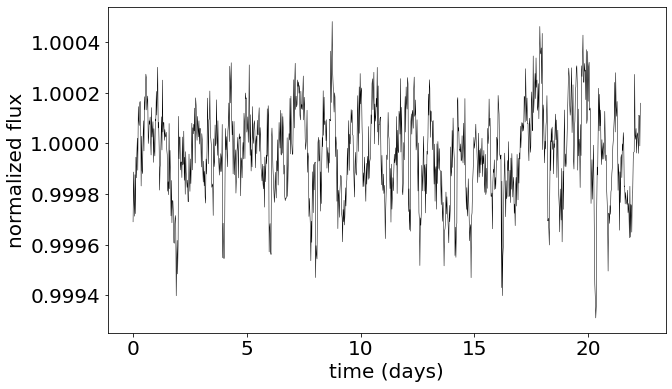

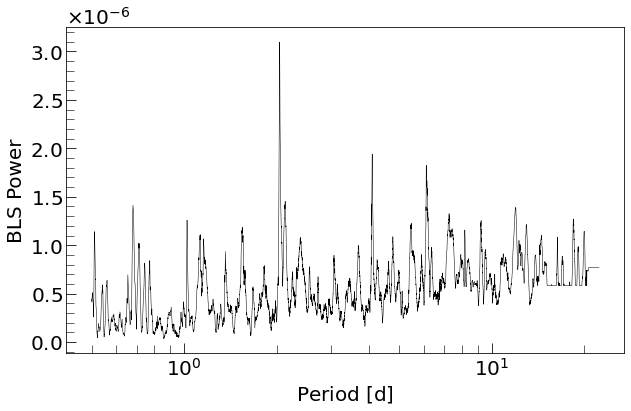

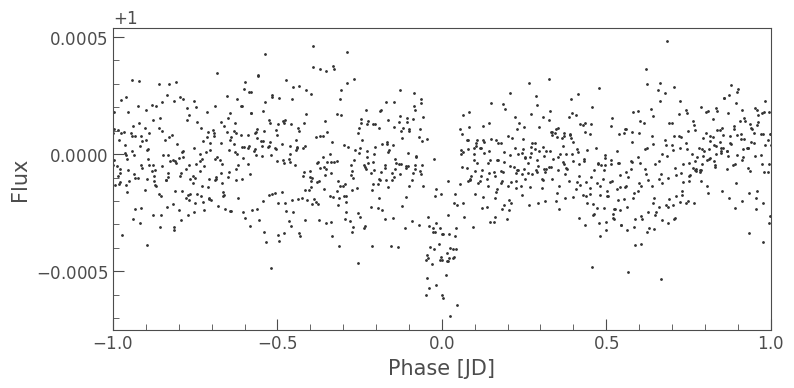

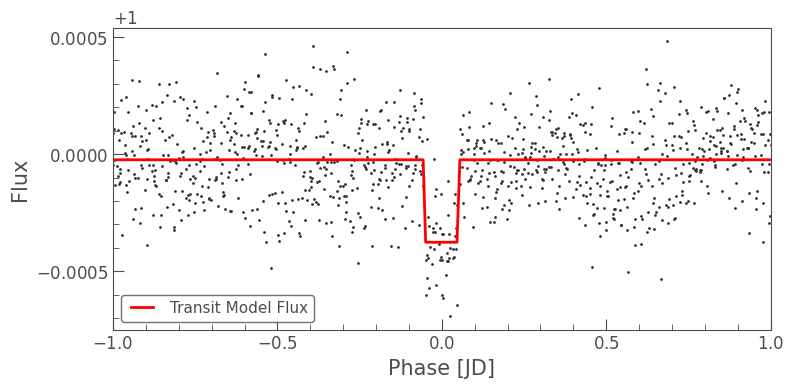

In [8]:
# def show_bls_fit(lc, planet_b_period, planet_b_t0=None, planet_b_dur=None, xlim=[-1., +1.]):
#     ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
#     ax.set_xlim(xlim[0], xlim[1]);

#     # Create a BLS model using the BLS parameters
#     planet_b_model = bls.get_transit_model(period=planet_b_period,
#                                            transit_time=planet_b_t0,
#                                            duration=planet_b_dur)

#     ax = lc.fold(planet_b_period, planet_b_t0).scatter()
#     planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
#     ax.set_xlim(xlim[0], xlim[1]);

matplotlib.rcParams.update({'font.size': 20})

def bls_routine(lc, best_fit=True, user_period=None, plot=True, xlim=[-1, +1]):
    """
    user_period must be one of the periods used to compute the periodogram
    """
    if not best_fit and not user_period:
        raise ValueError('If best_fit is set, user_period must be passed.')
    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        from matplotlib.ticker import FormatStrFormatter
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
        lc.plot(xlabel='time (days)', ylabel='normalized flux', ax=ax, c='black')

    # Create array of periods to search
    # period = 1 / (24 * np.arange(0.001869159, 0.4999767, 2.325541e-05))
    # period = 1 / (24 * np.arange(0.1, 0.4999767, 2.325541e-05))
    period = np.linspace(0.5, 22.2916666667, 21420)
    # period = 1 / (24 * np.linspace(0.001869159, 0.4999767, 21420))  # Instead of 0.12, if 0.4999767 is used, then freqs for TCF and BLS are exactly the same.
    # period = period[::-1]
    # Create a BLS Periodogram
    # bls = lc.to_periodogram(method='bls', period=None, frequency_factor=1/2, minimum_period=1, maximum_period=22);
    bls = lc.to_periodogram(method='bls', period=period, frequency_factor=0.5)
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        bls.plot(ax=ax, view='period', c='black');
        ax.set_xscale('log')
        ax.tick_params(length=10, direction='in', which='major')
        ax.tick_params(length=8, direction='in', which='minor')

    if best_fit:
        planet_b_period = bls.period_at_max_power
        planet_b_t0 = bls.transit_time_at_max_power
        planet_b_dur = bls.duration_at_max_power
        ind = np.where(bls.power.value == np.max(bls.power.value))[0][0]
        planet_b_t0A = bls.transit_time[ind]
        planet_b_durA = bls.duration[ind]
        assert planet_b_durA == planet_b_dur
        assert planet_b_t0A == planet_b_t0
    else:
        planet_b_period = user_period
        ind = np.where(bls.period.value == user_period)[0][0]
        planet_b_t0 = bls.transit_time[ind]
        planet_b_dur = bls.duration[ind]

    # Check the value for period
    if best_fit:
        print(f'Estimated period = {planet_b_period}')
    else:
        print(f'Period passed by the user = {user_period} days')

    if plot:
        ax = lc.fold(period=planet_b_period, epoch_time=planet_b_t0).scatter()
        ax.set_xlim(xlim[0], xlim[1]);

    # Create a BLS model using the BLS parameters
    planet_b_model = bls.get_transit_model(period=planet_b_period,
                                           transit_time=planet_b_t0,
                                           duration=planet_b_dur)

    if plot:
        ax = lc.fold(planet_b_period, planet_b_t0).scatter()
        planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
        ax.set_xlim(xlim[0], xlim[1]);

    return bls

bls = bls_routine(light_curve)

In [9]:
# bls.power[np.where(bls.power > 1.3e-6)[0][-73:-41]]

In [10]:
ind_A = np.where(bls.power > 1.15e-6)[0][11]
bls_false_peak_period_A = bls.period[ind_A]
ind_B = np.where(bls.power > 1.3e-6)[0][-60]
bls_false_peak_period_B = bls.period[ind_B]
bls_false_peak_period_A, bls_false_peak_period_B

(<Quantity 1.54283385 d>, <Quantity 11.93556344 d>)

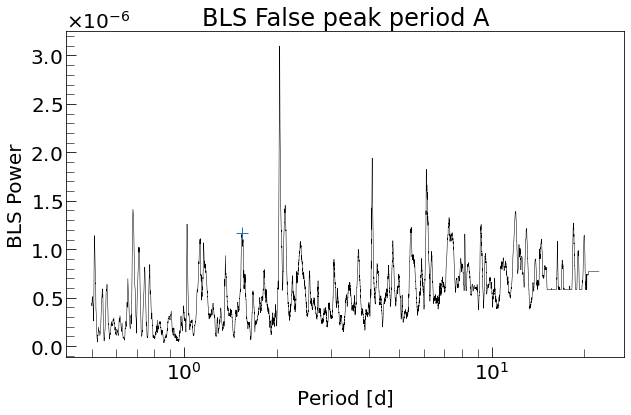

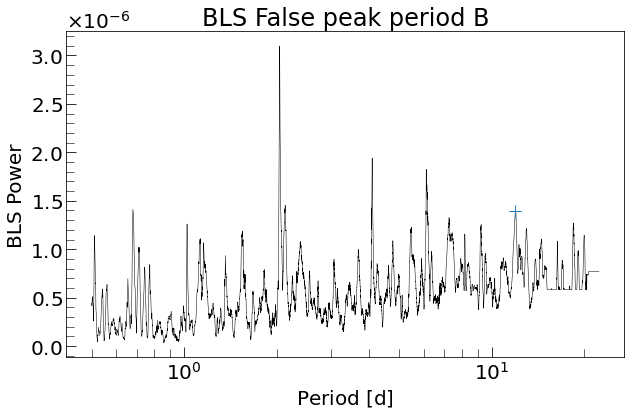

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xscale('log')
ax.tick_params(length=10, direction='in', which='major')
ax.tick_params(length=8, direction='in', which='minor')
bls.plot(ax=ax, view='period', c='black')
ax.plot(bls_false_peak_period_A.value, bls.power[ind_A].value, marker='+', markersize=12)
ax.set_title('BLS False peak period A');
ax.set_xscale('log');
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.set_xscale('log')
ax.tick_params(length=10, direction='in', which='major')
ax.tick_params(length=8, direction='in', which='minor')
bls.plot(ax=ax, view='period', c='black')
ax.plot(bls_false_peak_period_B.value, bls.power[ind_B].value, marker='+', markersize=12)
ax.set_title('BLS False peak period B');
ax.set_xscale('log');
plt.show()

`bls_false_peak_period_A` seems to be a half-integer harmonic.

Now checking the BLS fit at the two noise periods A and B.

Period passed by the user = 1.5428338546789064 days


BoxLeastSquaresPeriodogram(ID: None)

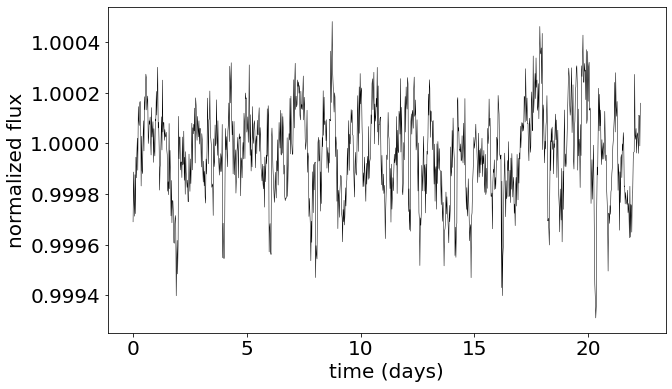

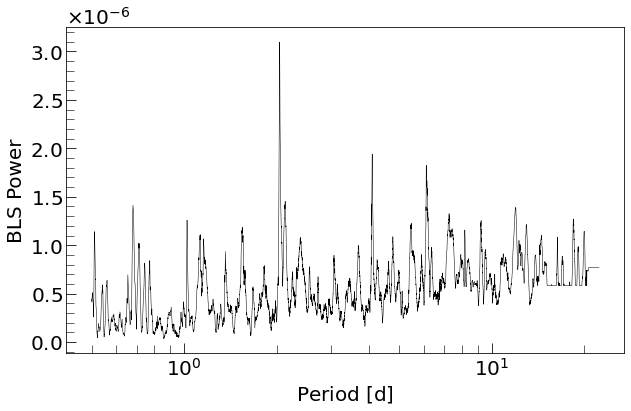

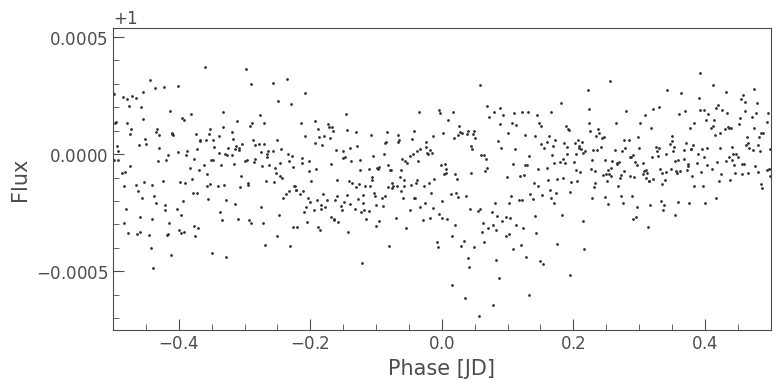

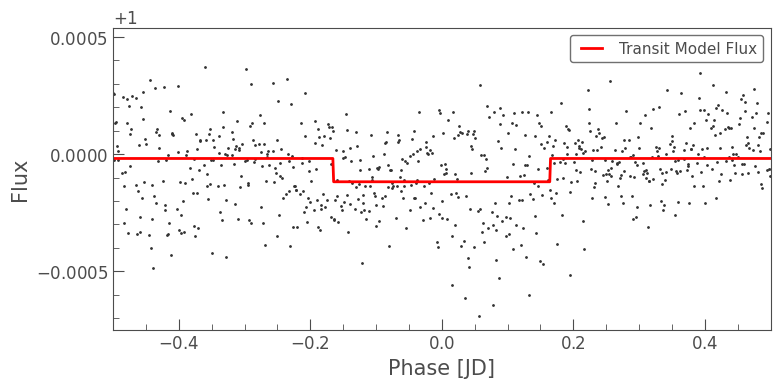

In [12]:
bls_routine(light_curve, best_fit=False, user_period=bls_false_peak_period_A.value, plot=True, xlim=[-0.5, +0.5])

Period passed by the user = 11.935563440576498 days


BoxLeastSquaresPeriodogram(ID: None)

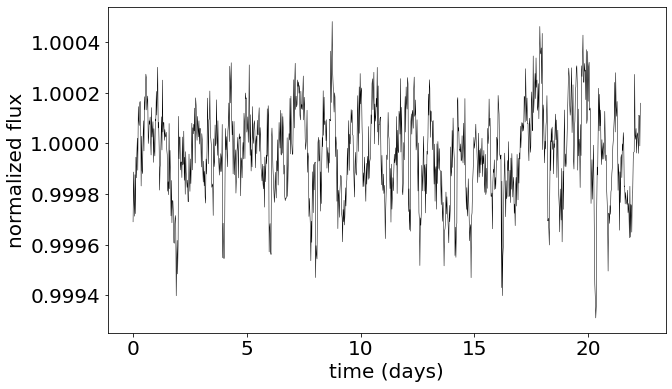

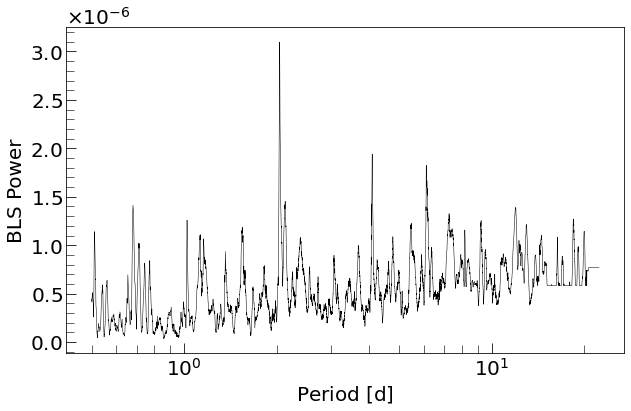

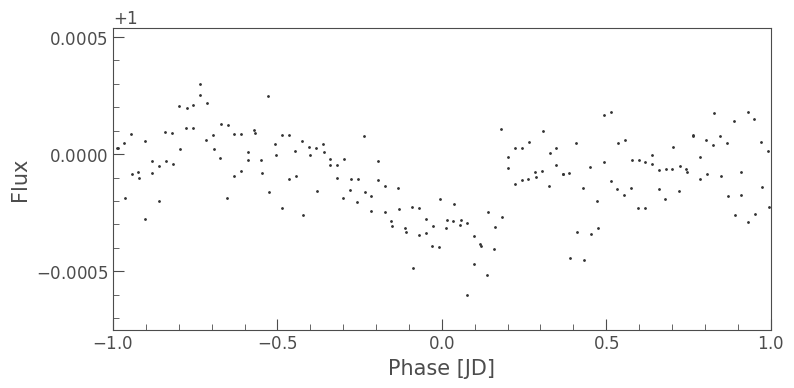

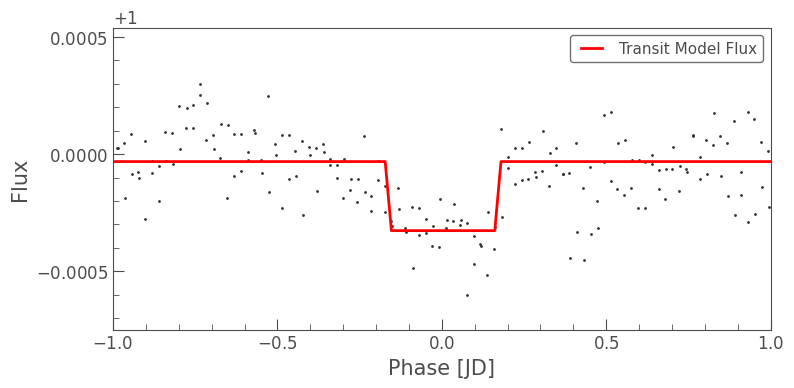

In [13]:
bls_routine(light_curve, best_fit=False, user_period=bls_false_peak_period_B.value, plot=True)

## TCF

Code used:

```R
df <- data.frame(diff_y=diff(y))
write.table(df, "diff_y", col.names=FALSE, row.names=FALSE, quote=FALSE)
```

<AxesSubplot:xlabel='Time [JD]', ylabel='Flux'>

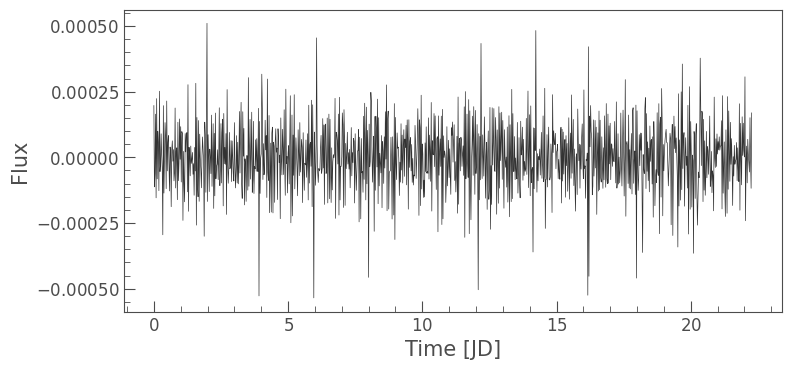

In [14]:
# arima_df = pd.read_csv('arima_fit', sep=' ', header=None)
diff_y = pd.read_csv('diff_y', header=None)
diff_y.columns = ['diff_y']
light_curve = lk.LightCurve(time=df['time'][:-1], flux=diff_y['diff_y'])
light_curve.plot()

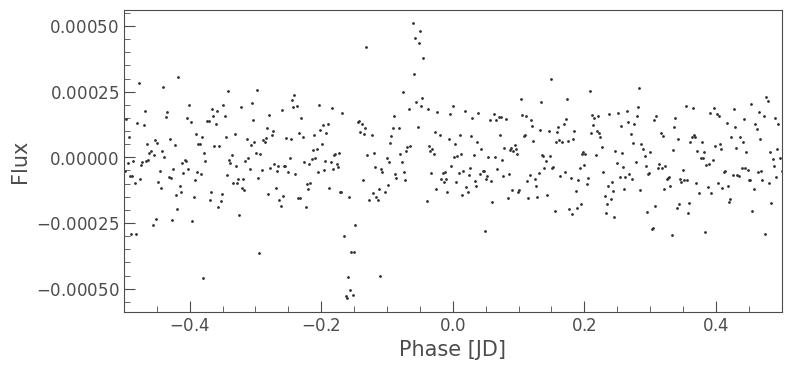

In [15]:
tcf_predicted_period = 2.03987300764
ax = light_curve.fold(period=tcf_predicted_period).scatter()
ax.set_xlim(-0.5, 0.5);

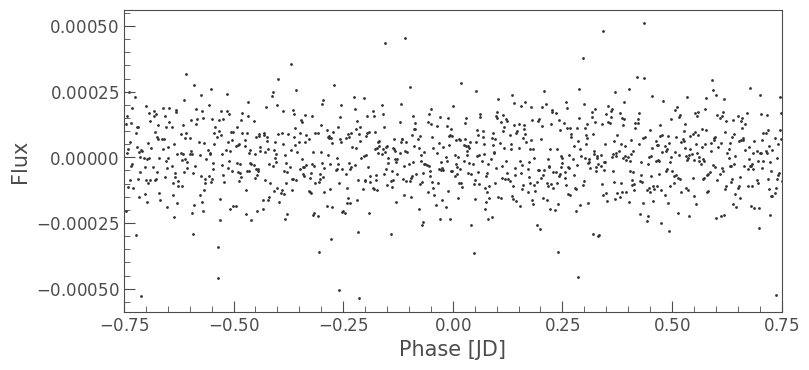

In [16]:
ax = light_curve.fold(period=bls_false_peak_period_A).scatter()
ax.set_xlim(-0.75, 0.75);

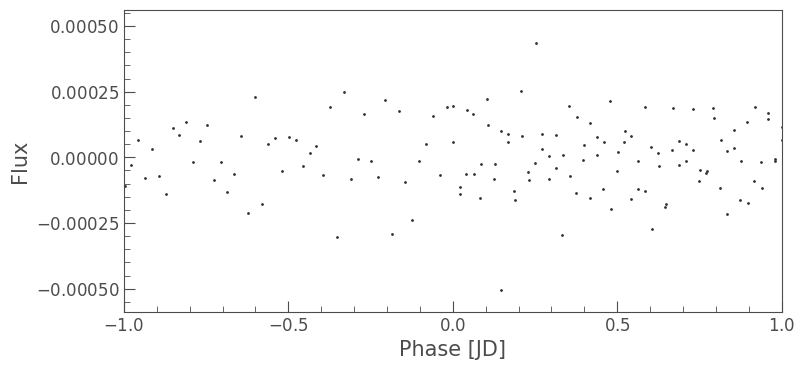

In [17]:
ax = light_curve.fold(period=bls_false_peak_period_B).scatter()
ax.set_xlim(-1, 1);

### Caveat: The same periods have **not** been used for TCF and BLS periodograms.

We decided that it is fine.

# Making the final figure

In [18]:
# Get the original light curve
df = pd.read_csv('ar_transit', sep=' ', header=None)
df.columns = ['flux', 'time', 'flux_err']
light_curve = lk.LightCurve(time=df['time'], flux=df['flux'])

gausspr_fit = pd.read_csv('gausspr_fit', sep=' ', header=None)
gausspr_fit.columns = ['flux', 'time']
light_curve = lk.LightCurve(time=df['time'], flux=df['flux'])
lc_gpr_fit = lk.LightCurve(time=gausspr_fit['time'], flux=gausspr_fit['flux'])

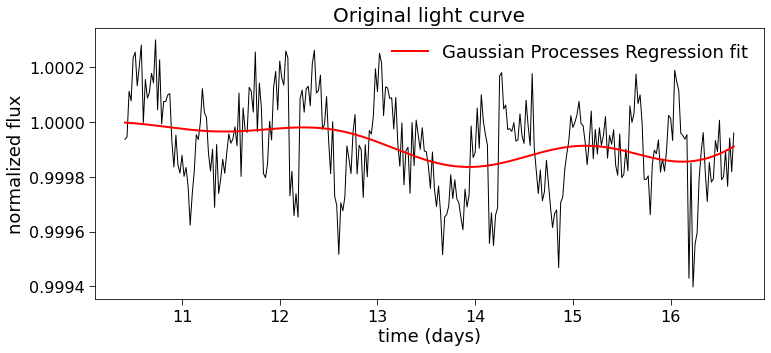

In [19]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
indices_range = (500, 800)
light_curve.iloc[indices_range[0]:indices_range[1]].plot(ax=ax, c='black', linewidth=1.0)
lc_gpr_fit.iloc[indices_range[0]:indices_range[1]].plot(ax=ax, c='red', linewidth=2, label='Gaussian Processes Regression fit')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=6, direction='out', which='major', labelsize=16)
ax.tick_params(length=4, direction='out', which='minor', labelsize=16)
ax.set_xlabel('time (days)', fontsize=18)
ax.set_ylabel('normalized flux', fontsize=18)
ax.legend(prop={'size': 18}, frameon=False)
ax.set_title('Original light curve', fontsize=20)

plt.savefig('1_1.png', bbox_inches='tight', dpi=300)

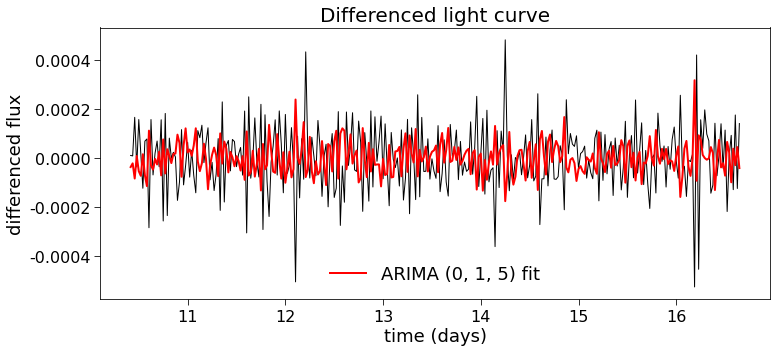

In [20]:
from matplotlib.ticker import FormatStrFormatter

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
indices_range = (500, 800)
ax.plot(arima_fit['time'][indices_range[0]:indices_range[1]], light_curve.iloc[indices_range[0]-1:indices_range[1]].flux.diff().value, c='black', linewidth=1.0)
ax.plot(arima_fit['time'][indices_range[0]:indices_range[1]], arima_fit['flux'][indices_range[0]:indices_range[1]], c='red', linewidth=2, label='ARIMA (0, 1, 5) fit')
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=6, direction='out', which='major', labelsize=16)
ax.tick_params(length=4, direction='out', which='minor', labelsize=16)
ax.set_xlabel('time (days)', fontsize=18)
ax.set_ylabel('differenced flux', fontsize=18)
ax.legend(prop={'size': 18}, frameon=False)
ax.set_title('Differenced light curve', fontsize=20)
plt.savefig('1_2.png', bbox_inches='tight', dpi=300)

Note that the maximum possible p and q orders would be 5 because we set an upper limit while using `auto.arima`.

One can observe how the transit is less apparent in the original light curve, but when differenced, the double-spikes can be clearly seen.

In [21]:
a_color = '#FC9272'
b_color =  '#1C9099'

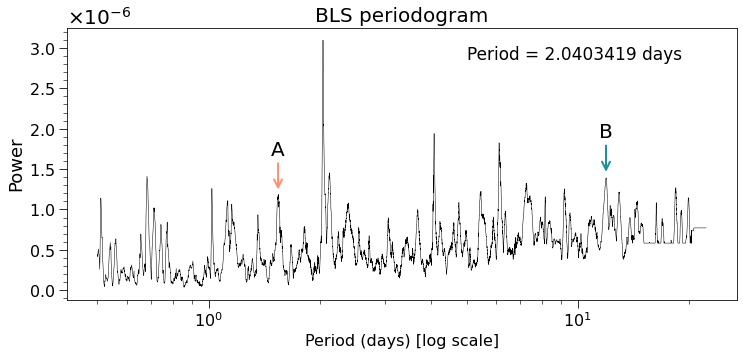

In [22]:
period = np.linspace(0.5, 22.2916666667, 21420)
bls = light_curve.to_periodogram(method='bls', period=period, frequency_factor=0.5)

fig, ax = plt.subplots(figsize=(12, 5))
bls.plot(ax=ax, view='period', c='black');
ax.set_xscale('log')
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=4, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Period (days) [log scale]', fontsize=16)
ax.set_ylabel('Power', fontsize=18)
ax.set_title('BLS periodogram', fontsize=20)

# ax.plot(bls_false_peak_period_A.value, bls.power[ind_A].value+1.5e-7, marker='+', markersize=12, c=a_color, mew=2.5)
# ax.plot(bls_false_peak_period_B.value, bls.power[ind_B].value+1.5e-7, marker='+', markersize=12, c=b_color, mew=2.5)
ax.text(5, 2.85e-6, f'Period = {np.round(bls.period_at_max_power.value, 7)} days', fontsize=17)

ax.annotate(
# Label and coordinate
'A', xy=(bls_false_peak_period_A.value, bls.power[ind_A].value+0.5e-7),xytext=(bls_false_peak_period_A.value, bls.power[ind_A].value+5e-7) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=2, color=a_color)
)
ax.annotate(
# Label and coordinate
'B', xy=(bls_false_peak_period_B.value, bls.power[ind_B].value+0.5e-7),xytext=(bls_false_peak_period_B.value, bls.power[ind_B].value+5e-7) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=2, color=b_color)
)


plt.savefig('2_1.png', bbox_inches='tight', dpi=300)

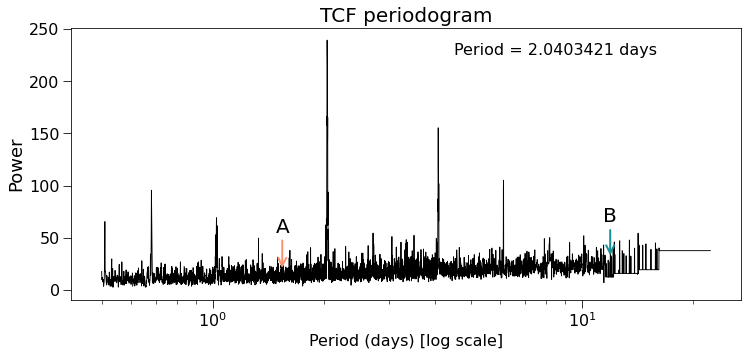

In [23]:
tcf = pd.read_csv('tcf_periodogram', sep=' ', header=None)
tcf.columns = ['power', 'periods']

tcf_estimated_period = 2.04034208333  # Found by running TCF in R.

# from lightkurve.periodogram import Periodogram
# lc_tcf_periodogram = Periodogram(frequency=tcf['periods']/24, power=tcf['power'])

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(tcf['periods']/24, tcf['power'], c='black', linewidth=0.9)
ax.set_xscale('log')
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=4, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Period (days) [log scale]', fontsize=16)
ax.set_ylabel('Power', fontsize=18)
ax.set_title('TCF periodogram', fontsize=20)

# ax.plot(bls_false_peak_period_A.value, tcf['power'][ind_A]+19, marker='+', markersize=12, c=a_color, mew=2.5)
# ax.plot(bls_false_peak_period_B.value, tcf['power'][ind_B]+31, marker='+', markersize=12, c=b_color, mew=2.5)
ax.text(4.5, 225, f'Period = {np.round(tcf_estimated_period, 7)} days', fontsize=16)

ax.annotate(
# Label and coordinate
'A', xy=(bls_false_peak_period_A.value, bls.power[ind_A].value+19),xytext=(bls_false_peak_period_A.value, bls.power[ind_A].value+55) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=2, color=a_color)
)
ax.annotate(
# Label and coordinate
'B', xy=(bls_false_peak_period_B.value, bls.power[ind_B].value+31),xytext=(bls_false_peak_period_B.value, bls.power[ind_B].value+65) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=2, color=b_color)
)

plt.savefig('2_2.png', bbox_inches='tight', dpi=300)

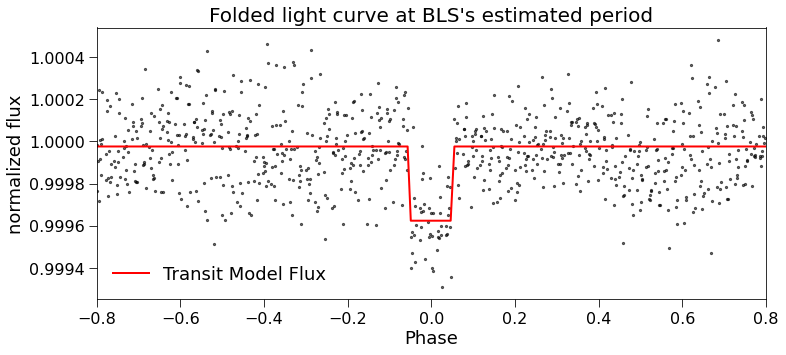

In [24]:
from matplotlib.ticker import FormatStrFormatter

planet_b_period = bls.period_at_max_power
planet_b_t0 = bls.transit_time_at_max_power
planet_b_dur = bls.duration_at_max_power
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

folded_lc = light_curve.fold(planet_b_period, planet_b_t0)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
folded_lc.scatter(ax=ax, c='#00000099', s=20)
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2, label='Transit Model Flux')
ax.set_xlim(-0.8, +0.8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=6, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Phase', fontsize=18)
ax.set_ylabel('normalized flux', fontsize=18)
ax.legend(frameon=False, fontsize=18)
ax.set_title("Folded light curve at BLS's estimated period", fontsize=20)
plt.savefig('3_1.png', bbox_inches='tight', dpi=300)

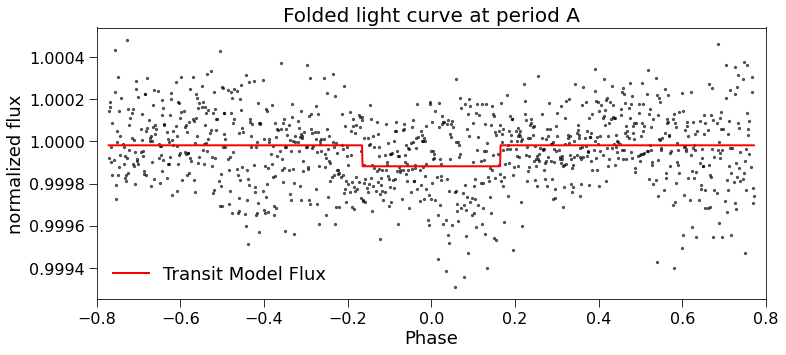

In [25]:
planet_b_period = bls_false_peak_period_A
planet_b_t0 = bls.transit_time[ind_A]
planet_b_dur = bls.duration[ind_A]
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
folded_lc = light_curve.fold(planet_b_period, planet_b_t0)
folded_lc.scatter(ax=ax, c='#00000099', s=20)
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-0.8, +0.8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=6, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Phase', fontsize=18)
ax.set_ylabel('normalized flux', fontsize=18)
ax.set_title('A', fontsize=18)
ax.legend(frameon=False, fontsize=18)
ax.set_title("Folded light curve at period A", fontsize=20)
plt.savefig('4_1.png', bbox_inches='tight', dpi=300)

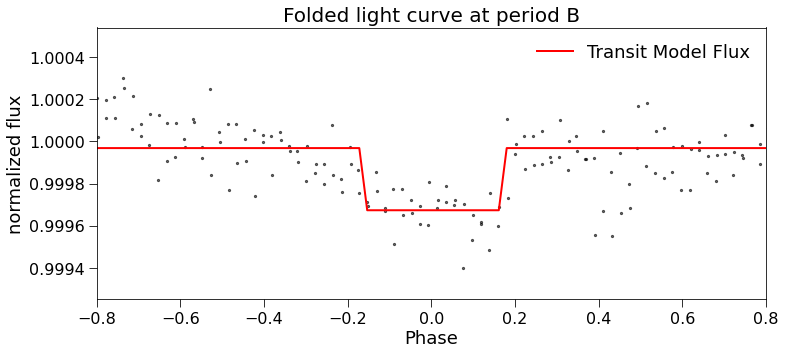

In [26]:
planet_b_period = bls_false_peak_period_B
planet_b_t0 = bls.transit_time[ind_B]
planet_b_dur = bls.duration[ind_B]
# Create a BLS model using the BLS parameters
planet_b_model = bls.get_transit_model(period=planet_b_period,
                                       transit_time=planet_b_t0,
                                       duration=planet_b_dur)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
folded_lc = light_curve.fold(planet_b_period, planet_b_t0)
folded_lc.scatter(ax=ax, c='#00000099', s=20)
planet_b_model.fold(planet_b_period, planet_b_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-0.8, +0.8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=6, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Phase', fontsize=18)
ax.set_ylabel('normalized flux', fontsize=18)
ax.set_title('B', fontsize=18)
ax.legend(frameon=False, fontsize=18)
ax.set_title("Folded light curve at period B", fontsize=20)
plt.savefig('5_1.png', bbox_inches='tight', dpi=300)

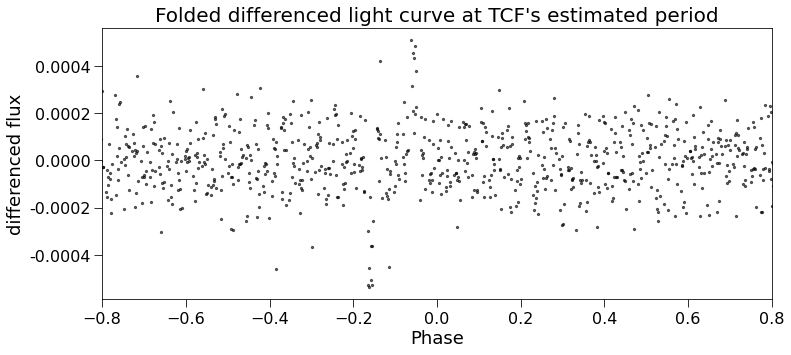

In [27]:
lc_diff = lk.LightCurve(time=arima_fit['time'], flux=light_curve.flux.diff().value)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
folded_lc = lc_diff.fold(period=tcf_estimated_period)
folded_lc.scatter(ax=ax, c='#00000099', s=20)

ax.set_xlim(-0.8, +0.8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=6, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Phase', fontsize=18)
ax.set_ylabel('differenced flux', fontsize=18)
ax.set_title("Folded differenced light curve at TCF's estimated period", fontsize=20)
plt.savefig('3_2.png', bbox_inches='tight', dpi=300)

Important to note that for all the three TCF folded plots (the one above and two below), the phase has not been adjusted - that's why the double-spike is not exactly at the center.

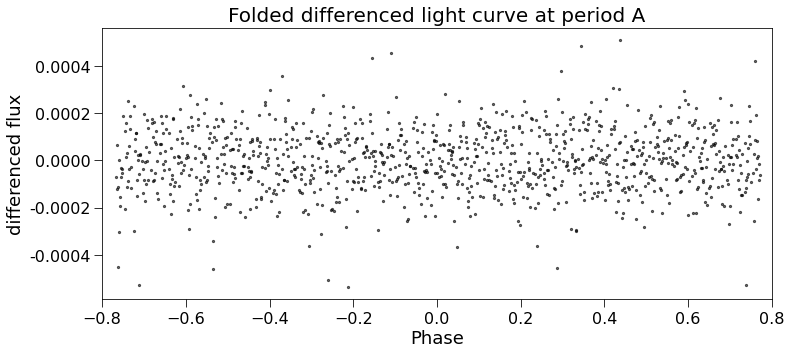

In [28]:
lc_diff = lk.LightCurve(time=arima_fit['time'], flux=light_curve.flux.diff().value)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
folded_lc = lc_diff.fold(period=bls_false_peak_period_A)
folded_lc.scatter(ax=ax, c='#00000099', s=20)

ax.set_xlim(-0.8, +0.8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=6, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Phase', fontsize=18)
ax.set_ylabel('differenced flux', fontsize=18)
ax.set_title("Folded differenced light curve at period A", fontsize=20)
plt.savefig('4_2.png', bbox_inches='tight', dpi=300)

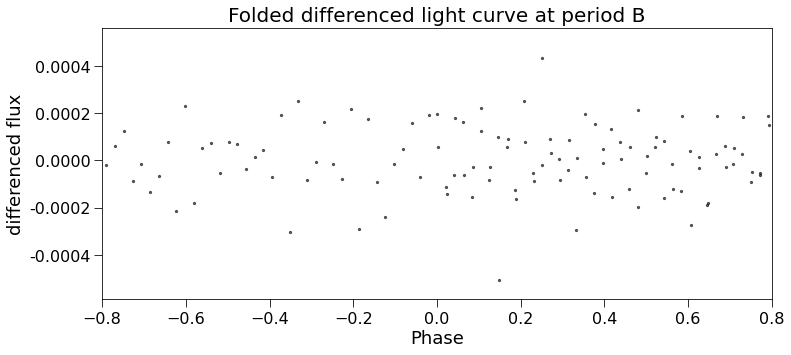

In [29]:
lc_diff = lk.LightCurve(time=arima_fit['time'], flux=light_curve.flux.diff().value)

fig, ax = plt.subplots(1, 1, figsize=(12, 5))
folded_lc = lc_diff.fold(period=bls_false_peak_period_B)
folded_lc.scatter(ax=ax, c='#00000099', s=20)

ax.set_xlim(-0.8, +0.8);
ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
ax.tick_params(length=8, direction='out', which='major', labelsize=16)
ax.tick_params(length=6, direction='out', which='minor', labelsize=16)
ax.set_xlabel('Phase', fontsize=18)
ax.set_ylabel('differenced flux', fontsize=18)
ax.set_title("Folded differenced light curve at period B", fontsize=20)
plt.savefig('5_2.png', bbox_inches='tight', dpi=300)